1. Use three layer autoencoder to obtain PCA types of low layer reconstruction
2. Freeze the low layer and train the reconstruction accuracy with upper layer
3. Use tensorboar to track the performance

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [8]:
# Load the image data
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('\tmp\data')

Extracting 	mp\data/train-images-idx3-ubyte.gz
Extracting 	mp\data/train-labels-idx1-ubyte.gz
Extracting 	mp\data/t10k-images-idx3-ubyte.gz
Extracting 	mp\data/t10k-labels-idx1-ubyte.gz


In [37]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=False)

X_train = mnist.train.images
X_train_demean = scaler.fit_transform(X_train)
graph = tf.Graph()
with graph.as_default():
    sess = tf.Session()
    y_train = sess.run(tf.cast(mnist.train.labels, tf.int32))

In [40]:
y_train.dtype

dtype('int32')

In [41]:
# Use 3 layer autoencoder to obtain the MNIST reconstruction accuracy
tf.reset_default_graph()

n_input = 784
n_hidden = 100
n_output = 10
learning_rate = 0.0001
l2_reg = 0.1
batch_size = 256
epochs = 2000

with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, n_input], name='X')
    y = tf.placeholder(tf.int32, shape=[None], name='y')

    initializer = tf.contrib.layers.variance_scaling_initializer()

    # regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

    w1_init = initializer([n_input, n_hidden])
    w2_init = initializer([n_hidden, n_output])

    w1 = tf.Variable(w1_init, dtype=tf.float32, name='w1')
    w2 = tf.Variable(w2_init, dtype=tf.float32, name='w2')

    hidden = tf.nn.relu(tf.matmul(X, w1))
    output = tf.nn.sigmoid(tf.matmul(hidden, w2))

    loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output))
    # l2_loss = regularizer(w1) + regularizer(w2)
    # loss = recon_loss

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init.run()
        recon_loss_track = []
        for i in range(epochs):
            for j in range(X_train_demean.shape[0]//batch_size):
                xi = X_train_demean[j*batch_size:(j+1)*batch_size, :]
                yi = y_train[j*batch_size:(j+1)*batch_size]
                train_op.run(feed_dict={X:xi, y:yi})
            if i % 100 == 0:
                print('Epoch{a}, loss={b}'.format(a=i,b=loss.eval(feed_dict={X:xi, y:yi})))
        output.eval(feed_dict={X:X_train_demean[0,:].reshape(-1, 784)})
        save_path = saver.save(sess, "/tmp/my_model_final_classification.ckpt")

Epoch0, loss=[ 1.92117763  1.87276149  1.81250572  1.84277296  1.9186008   1.92449462
  1.92147684  1.97107172  1.87386847  1.85242403  2.11087799  1.97061801
  1.89846385  1.81192803  1.94515491  2.07032299  2.09915042  1.82157695
  2.2135129   1.94345343  1.90432262  1.88630128  2.00766349  2.00760722
  1.98984957  2.15808201  1.85005462  1.80541396  1.87147307  1.87624192
  1.86224139  1.81909966  1.86802578  1.87095046  2.01459169  2.30973482
  1.90138936  1.96288097  1.90077138  1.85722494  1.98269963  1.89190495
  1.82392204  1.84404039  1.97299647  1.87781155  2.26007581  1.84772682
  2.24014235  1.83101106  1.83693206  1.84174681  1.93331063  2.05443144
  1.94565511  1.85697019  2.18086481  1.8899653   1.8356992   1.95674658
  1.96513069  1.89213252  2.10918045  1.93685985  1.82161498  2.02282548
  1.90293586  1.84727776  1.81731558  1.92585421  1.93881774  1.91079235
  2.17310429  1.86359429  1.97506309  1.98464227  1.97809374  1.91222811
  1.83555079  1.90985918  1.82892847  

KeyboardInterrupt: 

In [21]:
test_idx = 100
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    output_test = output.eval(feed_dict={X:X_train_demean[test_idx,:].reshape(-1, 784)})

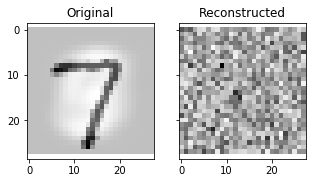

In [22]:
# Compare original and reconstructed inmages
fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2.5)
axes[0].imshow(X_train_demean[test_idx,:].reshape(28,28),cmap='Greys')
axes[0].set_title('Original')
axes[1].imshow(output_test.reshape(28, 28),cmap='Greys')
axes[1].set_title('Reconstructed')

In [23]:
# Visualze the weights
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    weight = w1.eval()

In [80]:
weight.shape

(784, 100)

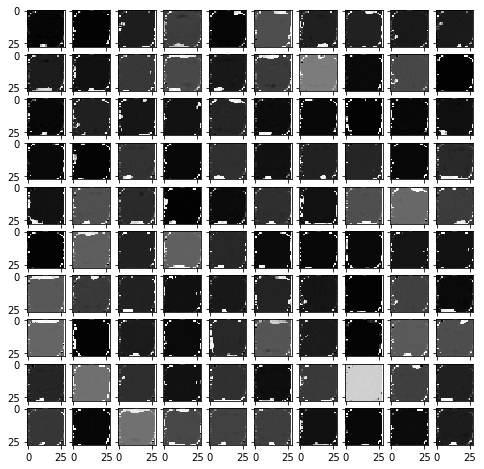

In [81]:
n_row = 10
n_col = 10
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(weight[:, i * n_col + j].reshape(28,28), cmap="Greys")

In [112]:
# Freeze the lower layer and train only the upper layer
n_input = 784
n_hidden = 100
n_ouput = 784
learning_rate = 0.0001
l2_reg=0.1
epochs = 1000
batch_size=256

# build the initializer and regularizer
initializer = tf.contrib.layers.variance_scaling_initializer()
regularizar = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(dtype=tf.float32, shape=[None, n_input],  name='X')

w1 = tf.constant(weight)
w2 = tf.Variable(initializer([n_hidden, n_output]), dtype=tf.float32, name='w2' )
# w2 = tf.get_variable('w2', shape=[n_hidden, n_output], initializer=initializer)

hidden = tf.nn.relu(tf.matmul(X, w1))
output = tf.matmul(hidden, w2)

recon_loss = tf.reduce_sum(tf.square(output - X))
loss = recon_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_var = [w2]
train_op = optimizer.minimize(recon_loss, var_list=train_var)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    
    for i in range(epochs):
        for j in range(X_train_demean.shape[0]//batch_size):
            xi = X_train_demean[j*batch_size:(j+1)*batch_size, :]
            train_op.run(feed_dict={X:xi})
        if i % 100 == 0:
            save_path = saver.save(sess, "/tmp/my_model_pretrained.ckpt")
            print('Epoch{a}, loss={b}'.format(a=i,b=loss.eval(feed_dict={X:xi})))
    output.eval(feed_dict={X:X_train_demean[0,:].reshape(-1, 784)})
    save_path = saver.save(sess, "/tmp/my_model_final_pretrained.ckpt")

Epoch0, loss=36673.33203125
Epoch100, loss=1261.7493896484375
Epoch200, loss=1210.6953125
Epoch300, loss=1210.4619140625
Epoch400, loss=1210.4542236328125
Epoch500, loss=1210.4530029296875
Epoch600, loss=1210.452880859375
Epoch700, loss=1210.4527587890625
Epoch800, loss=1210.4525146484375
Epoch900, loss=1210.452392578125


In [113]:
test_idx = 100
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final_pretrained.ckpt")
    output_test = output.eval(feed_dict={X:X_train_demean[test_idx,:].reshape(-1, 784)})

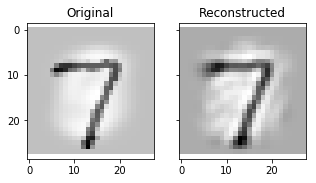

In [114]:
# Compare original and reconstructed inmages
fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2.5)
axes[0].imshow(X_train_demean[test_idx,:].reshape(28,28),cmap='Greys')
axes[0].set_title('Original')
axes[1].imshow(output_test.reshape(28, 28),cmap='Greys')
axes[1].set_title('Reconstructed')